In [1]:
%matplotlib inline
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

os.environ['PSRAD_PATH'] = '/scratch/uni/u237/users/lkluft/icon-aes/psrad/'
import conrad
import typhon


plt.style.use(typhon.plots.styles('typhon'))

def extract_scale(filename, regex='.*co2_x(.*)-.*\.nc'):
    """Extract the CO2 increase from filename.
    
    Parameters:
        filename (str): Path to netCDF file.
        
    Returns:
        str: Extracted CO2 factor if successful, filename if not.
        
    Examples:
        >>> extract_scale('results/tropical_co2_x0.5-conv_fVMR.nc')
        '0.5'
    """
    pattern = re.compile(regex)
    matches = pattern.match(filename)

    if matches:
        return matches.group(1)
    else:
        return filename
    

def get_legend_label(filename, label=r'$CO_2 \times {placeholder}$', **kwargs):
    """Get label for legend entry."""
    experiment = extract_scale(filename, **kwargs)
    
    return label.format(placeholder=experiment)


def flux_compensator(dataset):
    flux_keys = ['lw_flxu', 'lw_flxd', 'sw_flxu', 'sw_flxd']
    
    return [dataset.variables[key][:] for key in flux_keys]

# Refined grid visualisation

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10000.0, top=10000.0
  'bottom=%s, top=%s') % (bottom, top))


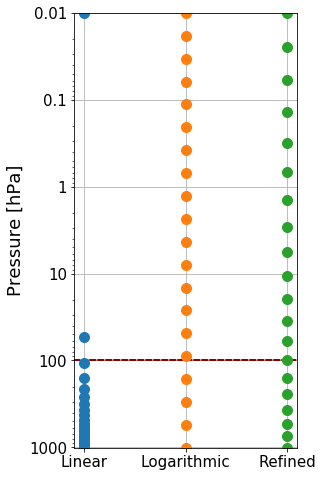

In [2]:
start, stop, num = 1013e2, 0.01e2, 20

p_refined = conrad.utils.refined_pgrid(start, stop, num, shift=0.5)
p_log = typhon.math.nlogspace(start, stop, num)
p_lin = np.linspace(start, stop, num)

fig, ax = plt.subplots(figsize=(4, 8))
ax.axhline(100e2, color='darkred', linestyle='dashed')
typhon.plots.profile_p_log(p_lin, 0* np.ones(p_lin.size), marker='o', linestyle='none')
typhon.plots.profile_p_log(p_log, 1 * np.ones(p_log.size), marker='o', linestyle='none')
typhon.plots.profile_p_log(p_refined, 2 * np.ones(p_refined.size), marker='o', linestyle='none')
ax.set_xticks(range(3))
ax.set_xticklabels(['Linear', 'Logarithmic', 'Refined'], rotation=0)
ax.grid(True)
fig.savefig('plots/refined_pgrid.pdf')

# Refined grid results

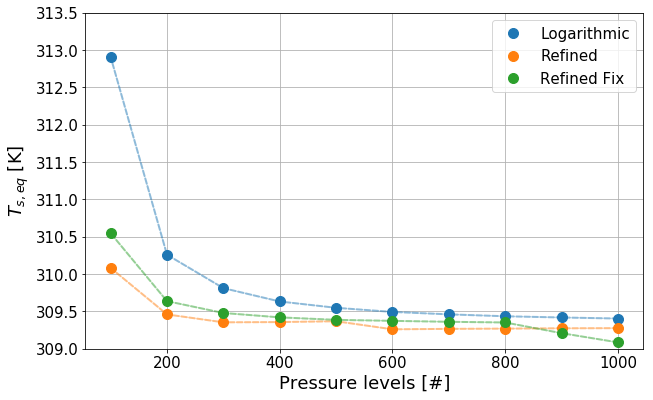

In [3]:
season = 'tropical-standard'

grid_log = sorted(
    glob.glob(conrad.utils.get_filepath(season, 'nlayers')),
    key=lambda fname: float(conrad.utils.extract_metadata(fname).scale),
    reverse=True,
)

grid_refined = sorted(
    glob.glob(conrad.utils.get_filepath(season, 'nlayers-refined')),
    key=lambda fname: float(conrad.utils.extract_metadata(fname).scale),
    reverse=True,
)

grid_refined_fix = sorted(
    glob.glob(conrad.utils.get_filepath(season, 'nlayers-refined-fix')),
    key=lambda fname: float(conrad.utils.extract_metadata(fname).scale),
    reverse=True,
)


if len(grid_log) * len(grid_refined) == 0:
    raise Exception('No input files found. Probably screwed glob pattern.')

legend_entry = ['Logarithmic', 'Refined', 'Refined Fix']

fig, ax = plt.subplots()
for n, grid_type in enumerate([grid_log, grid_refined, grid_refined_fix]):
    number_of_levels = [
        [int(conrad.utils.extract_metadata(f).scale), float(Dataset(f).variables['temperature'][-1])]
        for f in grid_type
    ]
    nlevels, Ts_eq = np.split(np.array(number_of_levels), 2, axis=1)

    ax.plot(nlevels, Ts_eq, marker='o', linestyle='none',
            color=f'C{n}', label=legend_entry[n])
    ax.plot(nlevels, Ts_eq, linestyle='--', alpha=0.5, color=f'C{n}')
ax.grid(True)
ax.set_xlabel('Pressure levels [#]')
ax.set_ylabel('$T_{s, eq}$ [K]')
ax.set_ylim(309., 313.5)
ax.legend()
fig.savefig('plots/layer_dependency_refined.pdf')

results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_1000.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_900.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_800.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_700.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_600.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_500.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_400.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_300.nc
results/tropical-convective/nlayers-convective-2xco2/tropical-convective_nlayers-convective-2xco2_200.nc
results/tropical-convective/nlayers-convective-2xco2/t

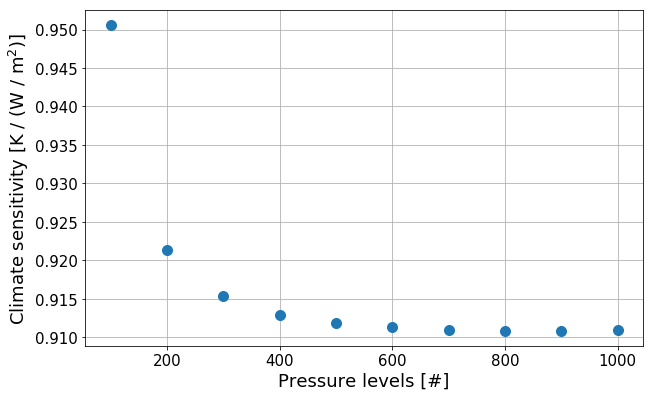

In [4]:
season = 'tropical-convective'
experiment = 'nlayers-convective-2xco2'

filenames = sorted(
    glob.glob(conrad.utils.get_filepath(season, experiment)),
    key=lambda fname: float(conrad.utils.extract_metadata(fname).scale),
    reverse=True,
)

if len(filenames) == 0:
    raise Exception('No input files found. Probably screwed glob pattern.')

fig, ax = plt.subplots()
for n, filename in enumerate(filenames):
    print(filename)
    nlevels = int(conrad.utils.extract_metadata(filename).scale)
    dataset = Dataset(filename)
    temp = dataset.variables['temperature'][1:]
    
    toa = conrad.utils.radiation_budget(*flux_compensator(dataset))[1:, -1]
    sensitivity, forcing = conrad.utils.equilibrium_sensitivity(temp, toa)

    ax.plot(nlevels, sensitivity, marker='o', linestyle='none', color='C0')
ax.grid(True)
ax.set_xlabel('Pressure levels [#]')
ax.set_ylabel('Climate sensitivity [K / (W / m$^2$)]')
# fig.savefig('plots/layer_dependency_true_sensitivity.pdf')

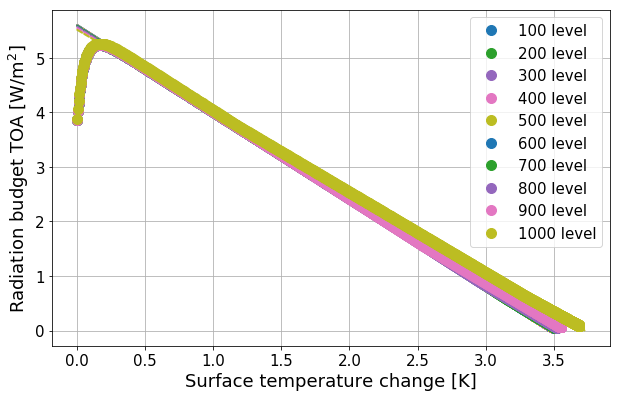

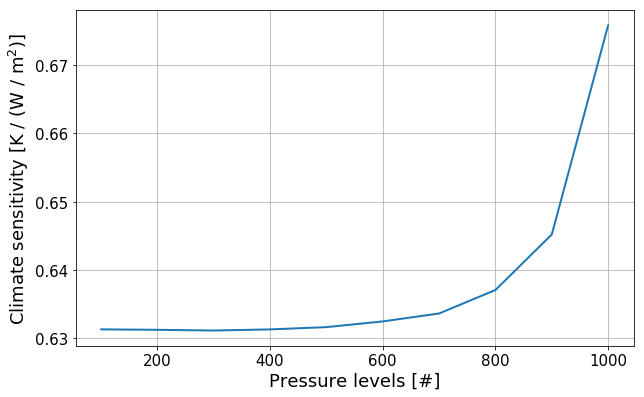

In [5]:
nlevels = np.arange(100, 1001, 100)
sensitvities = []
fig, ax = plt.subplots()
for level, filename in zip(nlevels, filenames):
    dataset = Dataset(filename)
    temperature = dataset.variables['temperature'][1:]
    toa = conrad.utils.radiation_budget(*flux_compensator(dataset))[1:, -1]

    s, F = conrad.plots.gregory_plot(temperature, toa, label=f"{level} level")
    sensitvities.append(s)
ax.legend()
    
fig, ax = plt.subplots()
ax.plot(nlevels, sensitvities)
ax.grid(True)
ax.set_xlabel('Pressure levels [#]')
ax.set_ylabel('Climate sensitivity [K / (W / m$^2$)]')
# fig.savefig('plots/layer_dependency_gregory_sensitivity.pdf')

# Improved algorithm

In [6]:
dataset_reference = Dataset('results/tropical_refined-layers_1000.nc')
dataset_improved = Dataset('results/tropical_refined-layers_1000_fast.nc')

days = dataset_reference.variables['time'][:] / 24
T_reference = dataset_reference.variables['T'][:, 100]
T_improved = dataset_improved.variables['T'][:, 100]

fig, ax = plt.subplots()
ax.plot(days, (T_improved - T_reference) / T_reference)
ax.set_xlabel('Days')
ax.set_xlim(left=0)
ax.set_ylabel('Relative difference')
ax.grid(True)

# fig.savefig('plots/improved_scheme_error.pdf')

OSError: No such file or directory